<a href="https://colab.research.google.com/github/Leandro-Braga/Estudo_de_Caso/blob/main/Atividade_Leandro_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Tema: Modelagem de dados para o modelo ARIMA 


O estudo da modelagem autorregressiva integráveis de médias móveis ARIMA, de larga utilização na modelagem de séries estacionárias e não estacionárias integradas, é essencial para o profissional na análise de séries temporais financeiras, econômicas, logísticas, de negócios, gestão, entre outras, pois apresentam características distintas como valores defasados e que ocorrem contemporaneamente e em vários momentos no passado.

A primeira coisa é verificar a estacionariedade nos dados. A estacionaridade será verificada pelo Teste Dicky Fuller Aumentado. A hipótese nula para este teste é que a Série Temporal é não Estacionária. Assim, se o valor de p for menor que 1, rejeitaremos a hipótese nula e acreditaremos que a série é Estacionária.

**Importação das bibliotecas necessárias**

In [32]:
# biblioteca de análise básica
import pandas as pd
import numpy as np
import seaborn as sns

# biblioteca de modelagem e testes
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm


# bibliotecas de visualização
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import plotly.offline as py
import plotly.graph_objs as go

# ignorando avisos
import warnings
warnings.filterwarnings('ignore')

In [33]:
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 16, 6
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['text.color'] = 'G'

**Exercício 01**: Geração dos 100 valores diários com início em janeiro de 2021 seguindo a distribuição normal com média 5,0 e variância 1,0. 

In [34]:
numero = 100
df = pd.DataFrame(dict(Day=pd.date_range("2021-01-01", 
                                           periods=numero),
                       Value=np.random.normal(5, 1, numero)))

In [35]:
df.head(100)

,Day,Value
0,2021-01-01,4.981908
1,2021-01-02,3.735783
2,2021-01-03,7.471479
3,2021-01-04,4.528730
4,2021-01-05,3.500091
...,...,...
95,2021-04-06,4.609276
96,2021-04-07,3.963099
97,2021-04-08,6.819652
98,2021-04-09,5.627134


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Day     100 non-null    datetime64[ns]
 1   Value   100 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.7 KB


Antes de fazer a decomposição da série, temos que transformar a data em índice:

In [37]:
# Transformando a data em índice

df.Day = pd.to_datetime(df.Day)
df.set_index('Day', inplace=True)

**Exercício 02**: Exibindo os dados em gráficos para analisar a distribuição.

In [38]:
# plotar gráfico de distribuição

grafico = [go.Scatter(x=df.index, y=df['Value'])]
py.iplot(grafico)

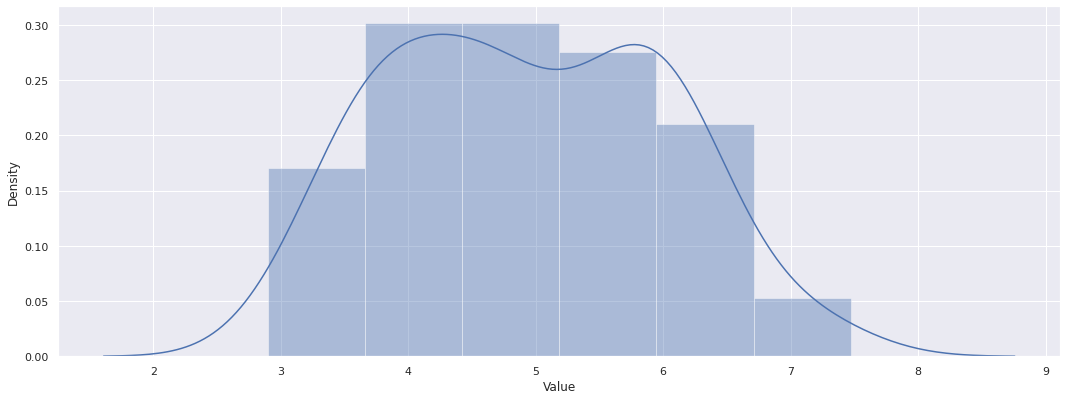

In [39]:
# Gráfico de histograma da representação aproximada da distribuição dos dados numéricos.

sns.set_theme(style="darkgrid")
sns.distplot(df['Value'].dropna())

#### Identificação

In [40]:
# Teste Dicky Fuller Aumentado

result = adfuller(df.Value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -13.143267
p-value: 0.000000


O resultado acima é constante desde que |f| < 1, caso em que o termo f aproxima-se de zero. Desse modo, o modelo AR(1) não estacionário, seria não estácionario se e somente se |f| > 1, confirmando a condição de estacionariedade desse modelo.

Antes de fazer a decomposição da série, temos que transformar a data em índice:

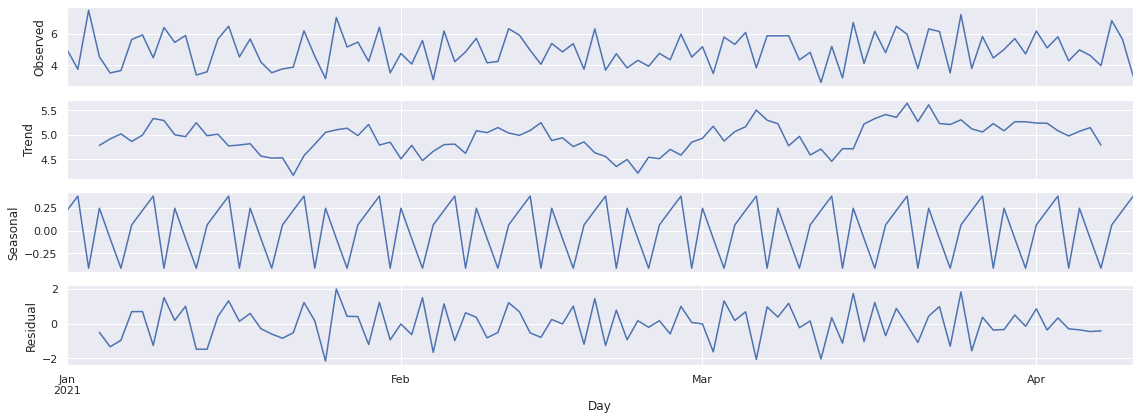

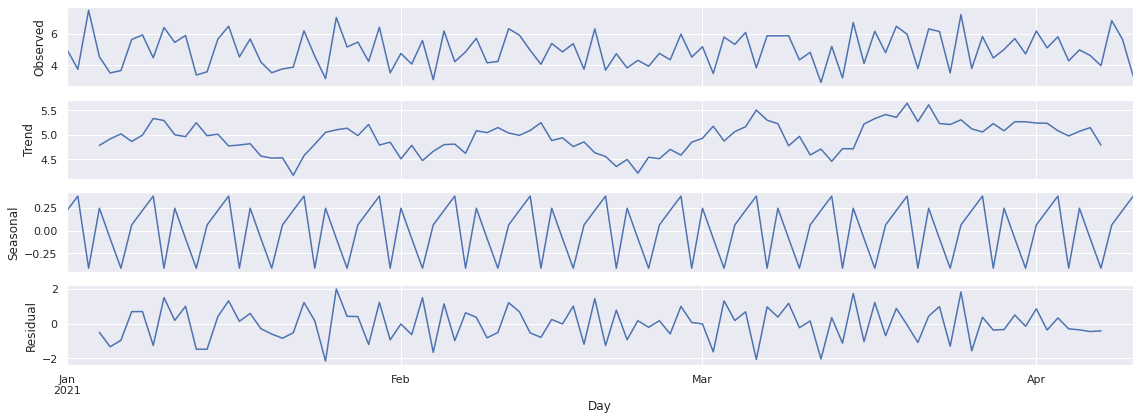

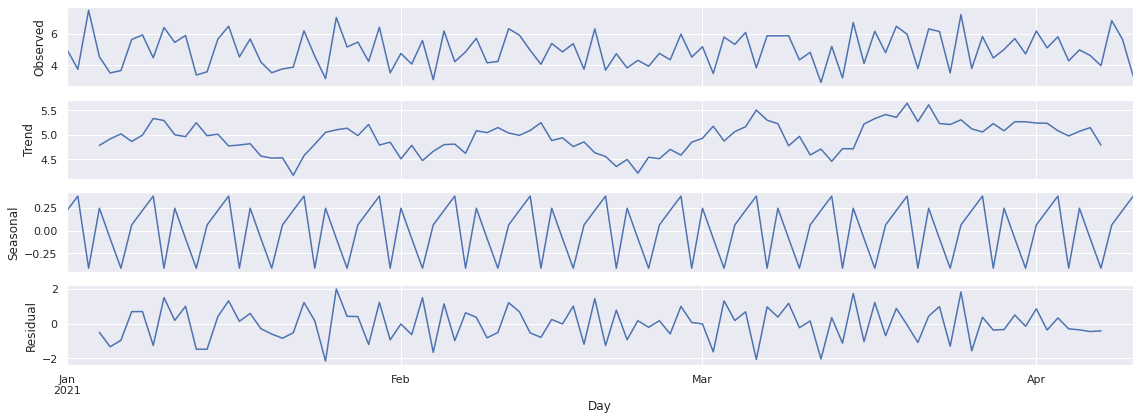

In [41]:
# salvar a decomposição no modelo aditivo

result_decompos = seasonal_decompose(x=df, model='additive')
fig = result_decompos.plot()
result_decompos.plot()

Vamos aplicar a decomposição multiplicativa à série:

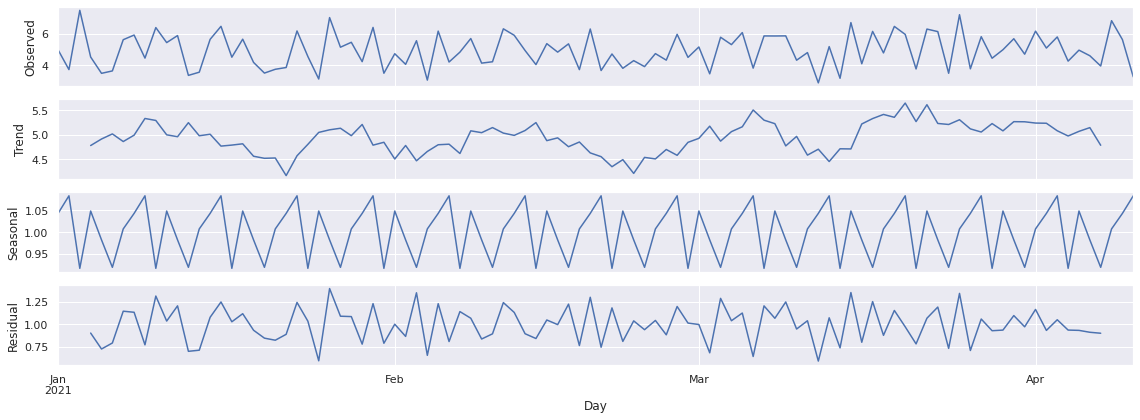

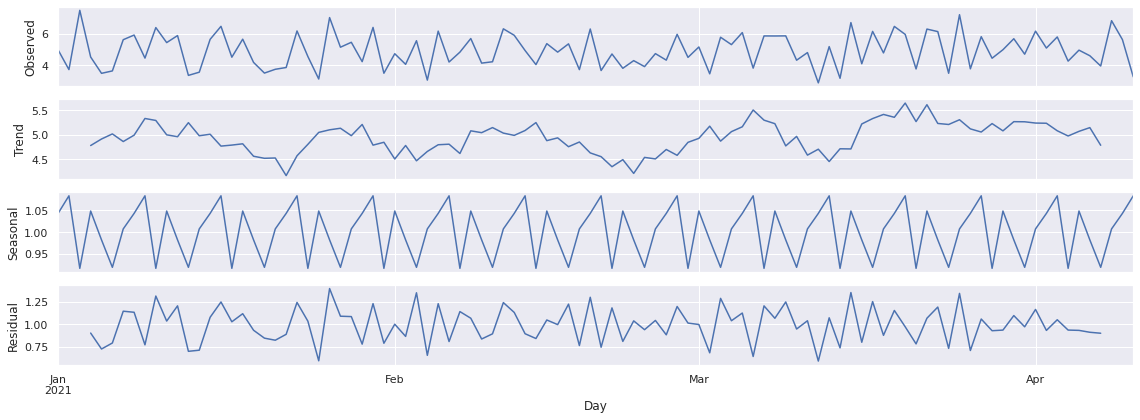

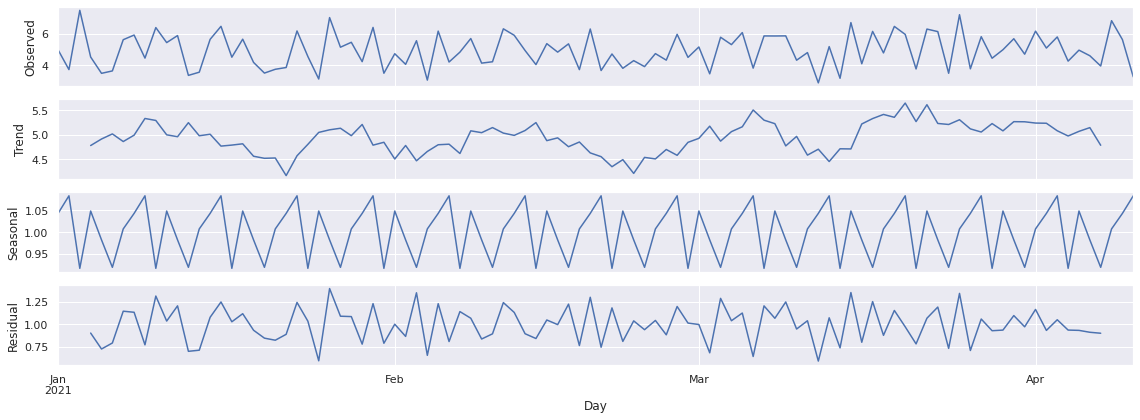

In [42]:
# Decomposição no modelo multiplicativo

result_decompos = seasonal_decompose(x=df, model='multiplicative')
fig = result_decompos.plot()
result_decompos.plot()

Observa-se um padrão muito similar entre os modelos de decomposição aditivo e multiplicativo, pois existe pouca ou nenhuma tendência na série. A diferença entre os modelos é maior quando a sazonalidade depende da tendência.

### Médias Móveis da série 

Consiste em utilizar como previsão a média simples das observações mais recentes. Consideraremos a média de k valores consecutivos, podemos tomar a média do último período, ou seja, os últimos 4 valores. O pacote Pandas tem funções específicas definidas para determinar médias móveis como:

Agora, vamos rodar o modelo de médias móveis para k=4, e o resultado obtido está ilustrado no gráfico a seguir:

Vamos executar o código com k=4.

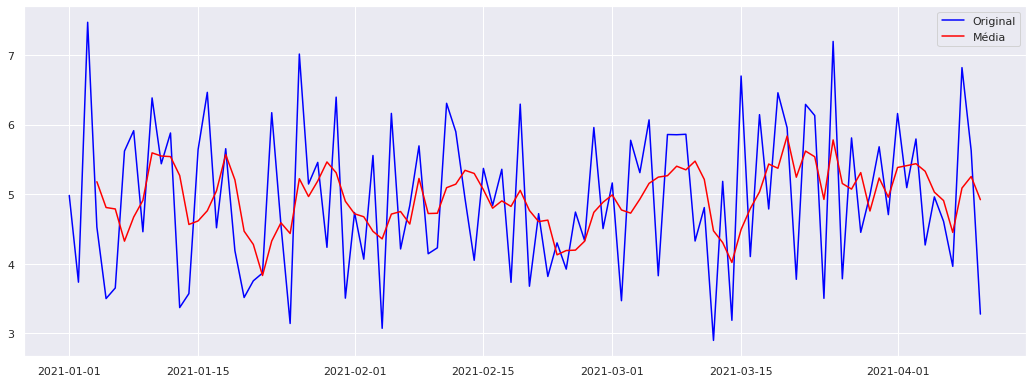

In [43]:
# Modelo de Médias Móveis da série com k=4

mm = pd.DataFrame.rolling(df,window=4,center=False).mean()
orig = plt.plot(df, color='blue',label='Original')
mean = plt.plot(mm, color='red',label='Média')
plt.legend(loc='best')
plt.show()

Para realizar previsões K passos à frente utilizando o modelo de médias móveis, utilizamos o seguinte código para previsão de 10 passos à frente:

In [44]:
def moving_average(series, n):
    '''Calcula a média das últimas n observações'''
    return np.average(series[-n:])

Calculando a previsão para 10 passos à frente:

In [45]:
# Previsão 10 passos à frente
moving_average(df, 10)

5.057627635195409

### Método amortecimento exponencial para séries logísticas

Vamos executar o código para Amortecimento Exponencial (sem constante de amortecimento) a seguir:

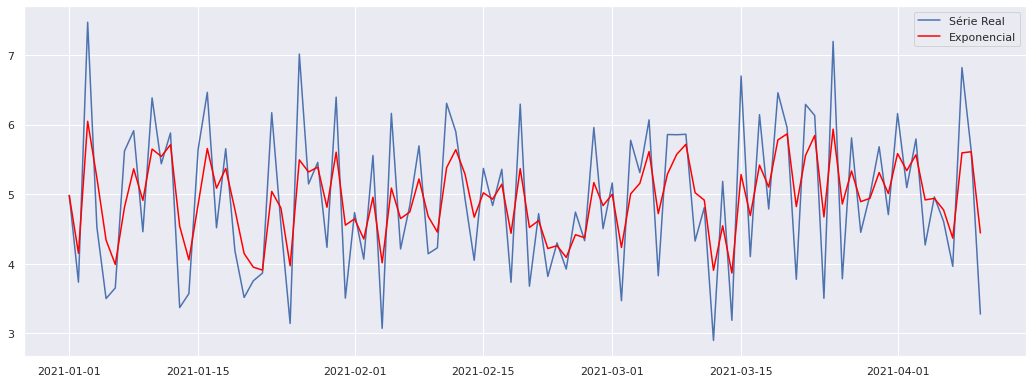

In [46]:
# Amortecimento Exponencial alfa = 0,5

rolling = df.ewm(alpha=0.5)
rolling_mean = rolling.mean()
plt.plot(df, label='Série Real')
plt.plot(rolling_mean, color='red', label='Exponencial')
plt.legend(loc='best')
plt.show()

Gráfico comparando mais de um valor da constante de amortecimento:

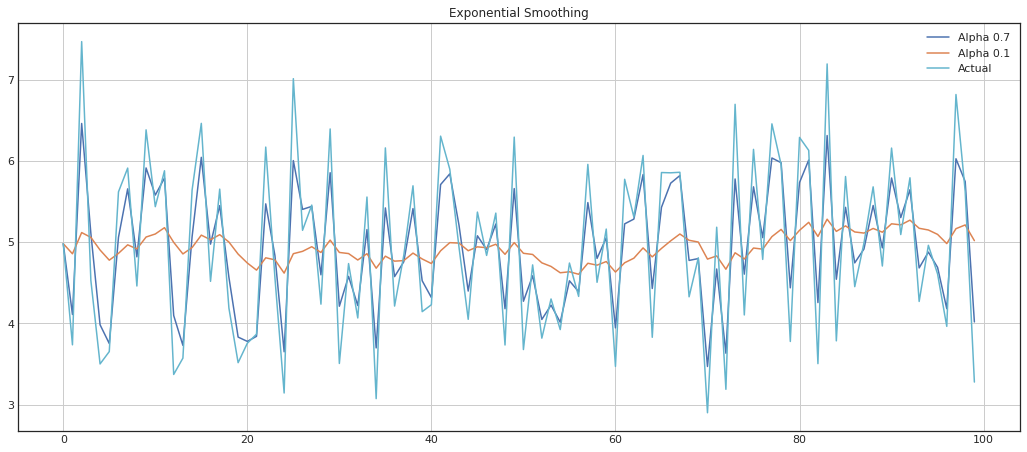

In [47]:
#Função para comparação com duas constantes de amortecimento:

def exponential_smoothing(series, alpha):
    '''
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    '''
    result = [series[0]] # o primeiro valor é o mesmo que a série
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
    
def plotExponentialSmoothing(series, alphas):
    '''
        Plota suavização exponencial com diferentes alfas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    '''
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(16, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label='Alpha {}'.format(alpha))
        plt.plot(series.values, 'c', label = 'Actual')
        plt.legend(loc='best')
        plt.axis('tight')
        plt.title('Exponential Smoothing')
        plt.grid(True);

plotExponentialSmoothing(df.Value, [0.7, 0.1])

Gráfico: Comparação com duas constantes de amortecimento.

### Método de Holt Winters para séries logísticas

O método de Holt-Winters compreende a equação de previsão e três equações de suavização.

Primeiramente, rodaremos o modelo de Holt-Winters somente com o nível e o alfa de 0,1:

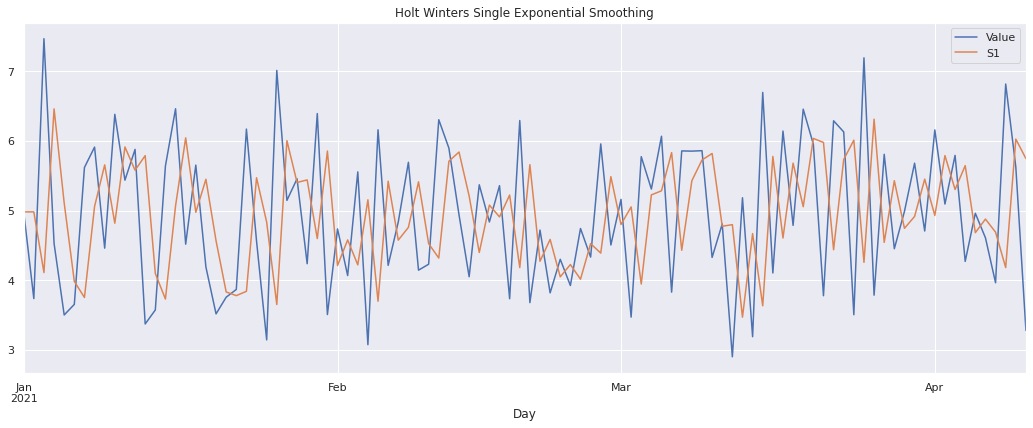

In [48]:
# holt winters (somente com o nível)

# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Set the value of Alpha and define m (Time Period)
alpha = 0.7
df['S1'] = SimpleExpSmoothing(df['Value']).fit(smoothing_level=alpha,
                                                  optimized=False,
                                                  use_brute=True).fittedvalues

df[['Value','S1']].plot(title='Holt Winters Single Exponential Smoothing');

Por último, temos o modelo de Holt-Winters com nível, com a tendência e sazonalidade, tanto para um modelo aditivo quanto multiplicativo:

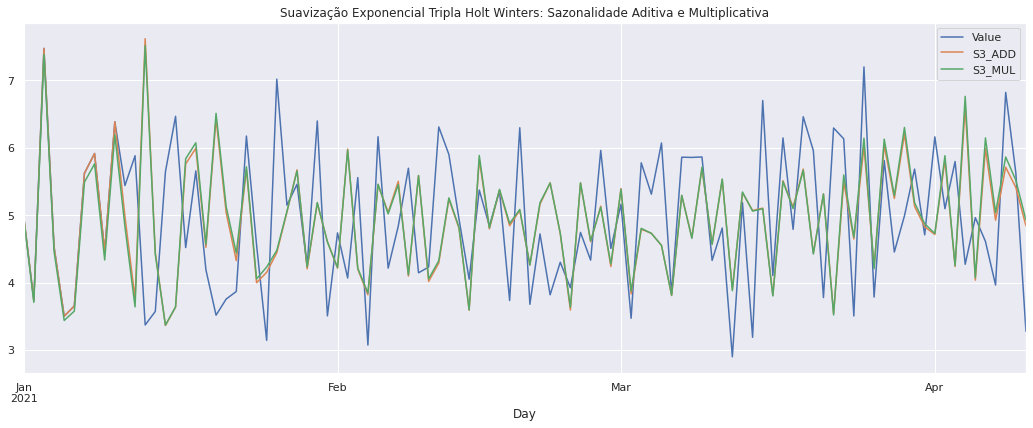

In [49]:
# holt winters (nível, tendência e sazonalidade, aditiva e multiplicativa)

df['S3_ADD'] = ExponentialSmoothing(df['Value'],trend='add',seasonal='add',seasonal_periods=10).fit().fittedvalues
df['S3_MUL'] = ExponentialSmoothing(df['Value'],trend='mul',seasonal='mul',seasonal_periods=10).fit().fittedvalues
df[['Value','S3_ADD','S3_MUL']].plot(title='Suavização Exponencial Tripla Holt Winters: Sazonalidade Aditiva e Multiplicativa')


Gráfico: Holt-Winters com nível, tendência e sazonalidade para modelo aditivo e modelo multiplicativo.

Vamos fazer a previsão, utilizando o modelo de Holt-Winters. Começaremos dividindo o conjunto de dados em treino e teste. Pegamos 90 dados como conjunto de treino e os últimos 10 últimos pontos de dados como conjunto de teste:

Text(0.5, 1.0, 'Treinamento, Teste e Previsão usando o Holt Winters')

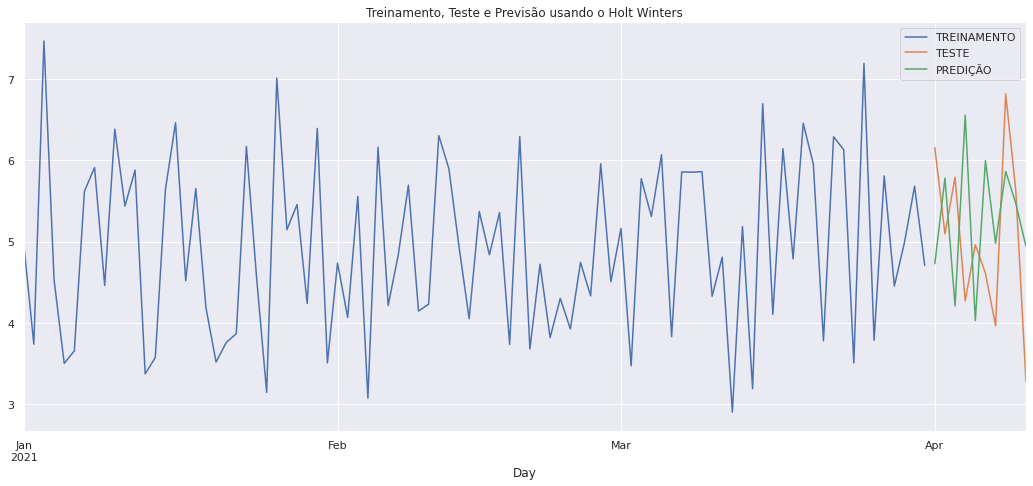

In [50]:
# Previsão 10 passos a frente com modelo de Holt-Winters

train_df = df[:90]
test_df = df[90:]
fitted_model = ExponentialSmoothing(train_df['Value'],trend='mul', 
                                    seasonal='mul',
                                    seasonal_periods=10).fit()
test_predictions = fitted_model.forecast(10)
train_df['Value'].plot(legend=True,label='TREINAMENTO')
test_df['Value'].plot(legend=True,label='TESTE',figsize=(16,7))
test_predictions.plot(legend=True,label='PREDIÇÃO')
plt.title('Treinamento, Teste e Previsão usando o Holt Winters')

Gráfico: Previsão 10 passos à frente com modelo de Holt-Winters.

In [51]:
# 10 Valores previstos

test_predictions

2021-04-01    4.726772
2021-04-02    5.783112
2021-04-03    4.207597
2021-04-04    6.557590
2021-04-05    4.027595
2021-04-06    5.999641
2021-04-07    4.980166
2021-04-08    5.864504
2021-04-09    5.471786
2021-04-10    4.940639
Freq: D, dtype: float64

Podemos observar que as previsões feitas com o modelo de Holt-Winters se ajustam bem, pois, comparando o período de teste com os valores previstos, vemos que existe o mesmo comportamento na série.

### Modelagem ARIMA 

Utilizaremos a metodologia proposta por Box & Jenkins para a análise da série temporal. A identificação anterior não pretende definir o modelo final para representar a série. Se assim fosse, não haveria necessidade das outras etapas de modelagem. Como já vimos, o objetivo é apenas definir os valores de p, d e q que, inicialmente, sejam adequados para modelar a série, segundo os autores do método, esse diagnóstico costuma conduzir a um modelo subespecificado, menor do que o modelo verdadeiro para a série.

Iremos fazer os gráficos da função de autocorrelação (FAC) e função de autocorrelação parcial (FAC) para confirmar se a série é estacionária.

In [52]:
# exibir os principais dados
df.head()

,Value,S1,S3_ADD,S3_MUL
Day,,,,
2021-01-01,4.981908,4.981908,4.981908,4.961652
2021-01-02,3.735783,4.981908,3.735783,3.706304
2021-01-03,7.471479,4.109620,7.471479,7.385720
2021-01-04,4.528730,6.462921,4.528730,4.461564
2021-01-05,3.500091,5.108987,3.500091,3.437250


In [54]:
df_novo = df.drop(columns=['S1', 'S3_ADD','S3_MUL'])
# df_novo = df
df_novo.head()

,Value
Day,
2021-01-01,4.981908
2021-01-02,3.735783
2021-01-03,7.471479
2021-01-04,4.528730
2021-01-05,3.500091


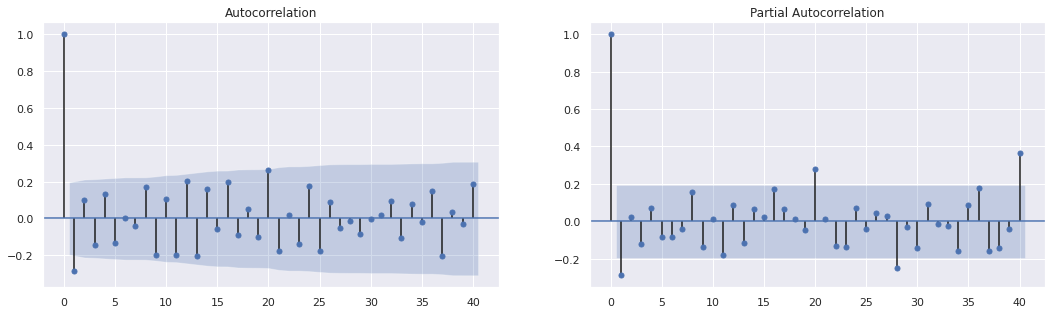

In [55]:
# Função de autocorrelação (FAC) e função de autocorrelação parcial (FAC)

def acf_pacf(x):
  
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=40, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=40, ax=ax2)

acf_pacf(df_novo)

Observa-se que a FAC (Função de Autocorrelação) decai exponencialmente como senoides amortecidas e a FACP (Função de Autocorrelação Parcial) possui o lag 1 significativo, ou seja, truncada no lag 1, o que sugere um modelo de médias móveis de ordem 1.

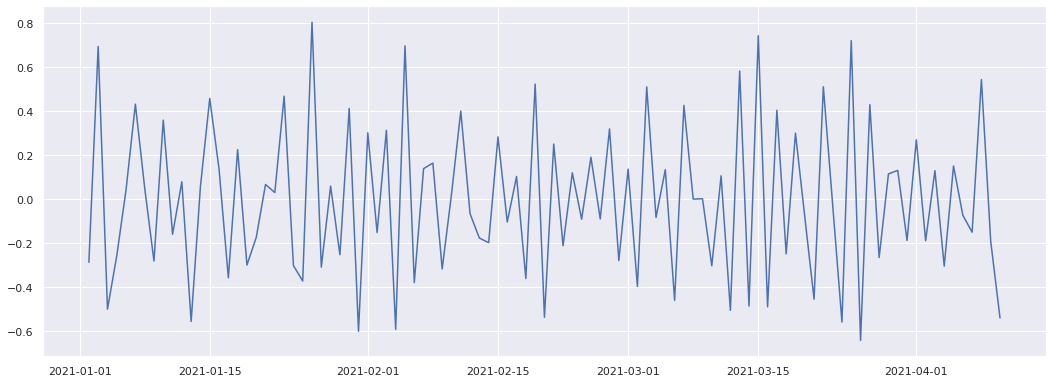

In [56]:
#Transformação para tornar a série estacionária
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
ax.plot(np.log(df_novo).diff().dropna());

Dessa maneira, o procedimento sugerido por Box & Jenkins para a identificação das ordens p e q de um modelo de séries temporais é, a partir da série que se quer analisar, estimar a FAC obtendo o gráfico da FAC e da FACP amostral.

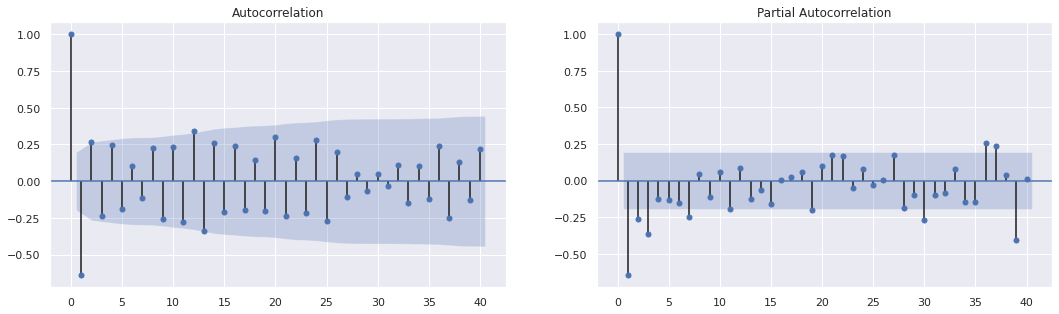

In [57]:
# FAC e FACP para série estacionária

acf_pacf(np.log(df_novo).diff().dropna())

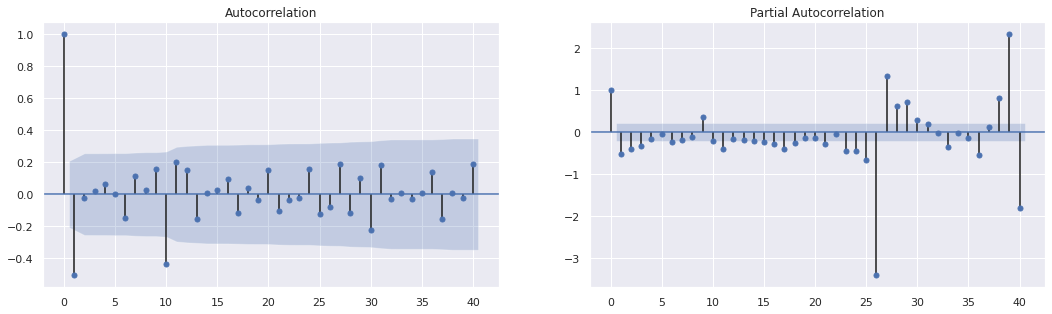

In [58]:
# FAC e FACP para série estacionária

acf_pacf(np.log(df_novo).diff().diff(10).dropna())

Gráfico: FAC e FACP para série estacionária.

A série transformada, após uma diferença, ou seja, foi identificado que d=1 e aplicada à função logarítmica ficou não estacionária. E como a condição para estimar o modelo ARIMA é que a série não seja estacionária, podemos seguir com a análise:

Observamos que, mesmo após a diferença, a série apresenta os pontos fora do intervalo de confiança; esses pontos estão ocorrendo a cada lag múltiplo de 10, o que caracteriza que necessita de diferença sazonais.

Estimaremos um modelo ARIMA(p,d,q) conforme enunciado do Exercício 04, para prever 10 valores posteriores a n, e em seguida exibir um gráfico Real x Estimado.

Primeiro dividiremos os dados para teste e treinamento:

In [59]:
# dados_treinamento, dados_teste = df[0:int(len(df)*0.7)], df[int(len(df)*0.7):]

df_treinamento, dados_teste = df_novo[0:int(len(df_novo)*0.7)], df_novo[int(len(df_novo)*0.7):]
df_treinamento = df_treinamento['Value'].values
dados_teste = dados_teste['Value'].values
df_historico = [x for x in df_treinamento]
modelo_pred = []

In [60]:
obs_teste = len(dados_teste)

for p_teste in range(obs_teste ):
  modelo = ARIMA(df_historico, order=(1,1,1))  
  modelo_fit = modelo.fit(disp=0)
  saida = modelo_fit.forecast()
  yt = saida[0]
  modelo_pred.append(yt)
  valor_R_teste = dados_teste[p_teste]
  df_historico.append(valor_R_teste)

In [61]:
# Geração validação pelo erro quadrático médio

erroMSE = mean_squared_error(dados_teste, modelo_pred)
print('O Erro Médio Quadrático (MSE) é {}'.format(erroMSE))

O Erro Médio Quadrático (MSE) é 1.2009999652172532


Em estatística, o erro quadrático médio ou desvio quadrático médio de um estimador mede a média dos quadrados dos erros, ou seja, a diferença quadrática média entre os valores estimados e o valor real.

Porém, como mencionado antes, esse não necessariamente é o modelo final, uma vez que o procedimento de identificação tende a subidentificar o modelo, isto é, a conduzir a valores de p e/ou q que são menores que os reais. Uma vez identificado e estimado um modelo, devemos diagnosticar o modelo e verificar se os resíduos apresentam as propriedades esperadas para eles. Ou seja, se eles se comportam como um ruído branco.

Faremos mais uma transformação, elevando ao quadrado o valor da variação:

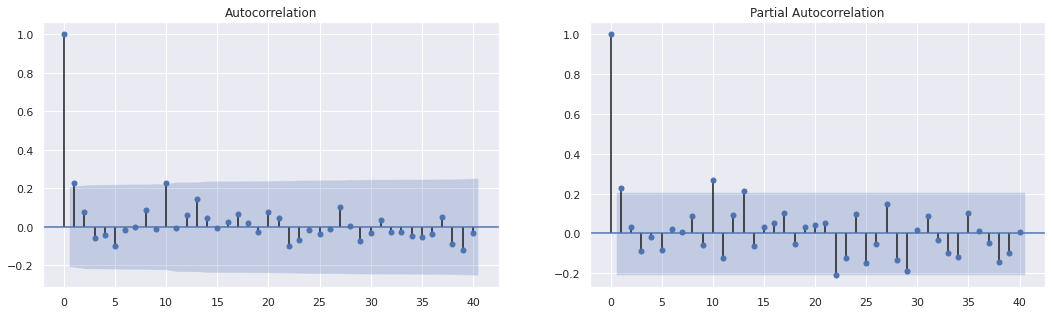

In [62]:
acf_pacf(np.log(df_novo).diff().diff(10).dropna() ** 2)

Gráfico: Modelo ARIMA(p,d,q).

O valor da série da PIM transformada apresenta tanto características de AR(1) como de MA(1), caracterizando um processo ARMA(1,1), pois a FAC de um MA(1) é truncada em q=1 e a FACP de um AR(1) é truncada em p=1. Essa é a fase de identificação.

Na fase de estimação, estimamos os parâmetros do modelo, sendo assim, estimaremos o modelo ARIMA(p,d,q), em que p=1, q=1 e d=1, sendo um ARIMA(1,1,1):

In [63]:
# Ajuste do modelo ARIMA(1,1,1)

model2 = sm.tsa.ARIMA(1000 * (np.log(df_novo).diff().dropna() ** 2), 
                     order=(1,1,1)).fit()
print(model2.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                   98
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -622.267
Method:                       css-mle   S.D. of innovations            135.681
Date:                Fri, 28 Jan 2022   AIC                           1252.534
Time:                        03:09:23   BIC                           1262.874
Sample:                    01-03-2021   HQIC                          1256.717
                         - 04-10-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1691      0.664      0.255      0.799      -1.131       1.470
ar.L1.D.Value     0.2893      0.098      2.949      0.004       0.097       0.482
ma.L1.D.Value    -0.9999      0.029    -

Ajuste do modelo ARIMA(1,1,1)

**O passo mais importante é detectar a possibilidade de autocorrelação. Se os resíduos apresentarem algum padrão de dependência temporal.**

Para começar a fase de diagnóstico, vamos fazer o gráfico dos resíduos:

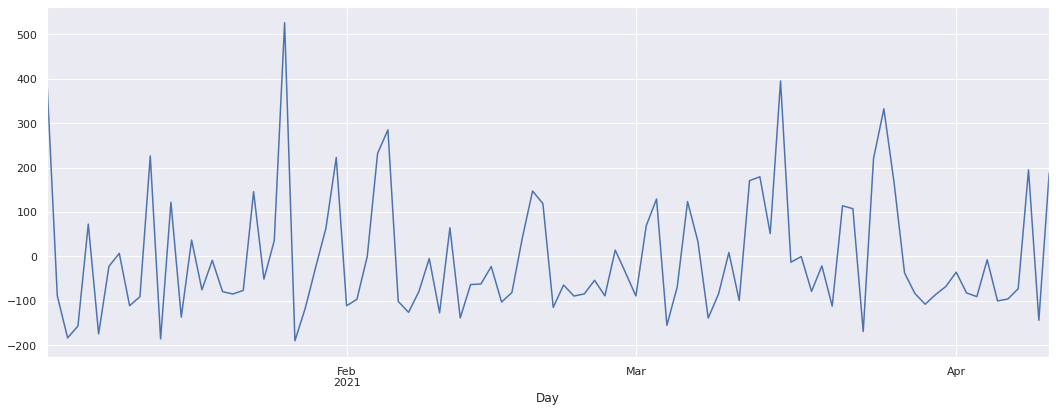

In [64]:
# Gráfico dos resíduos
model2.resid.plot()

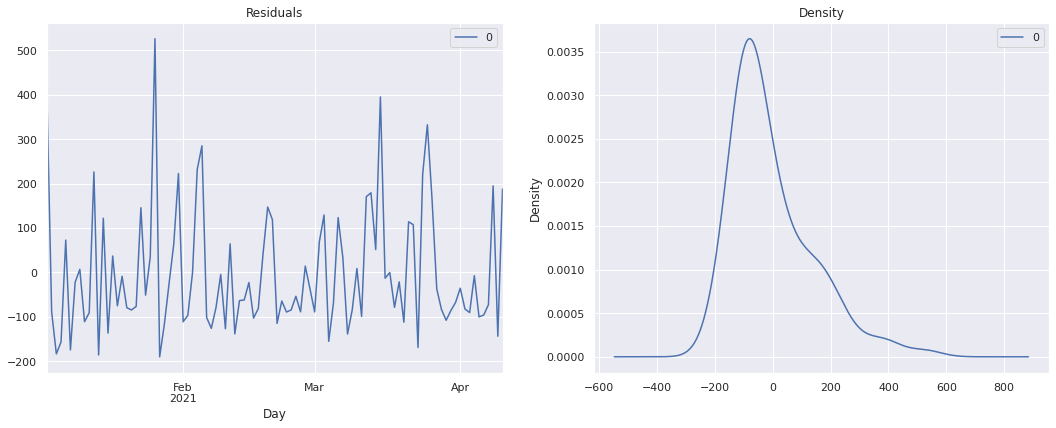

In [65]:
residuals = pd.DataFrame(model2.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Gráfico: Resíduos.

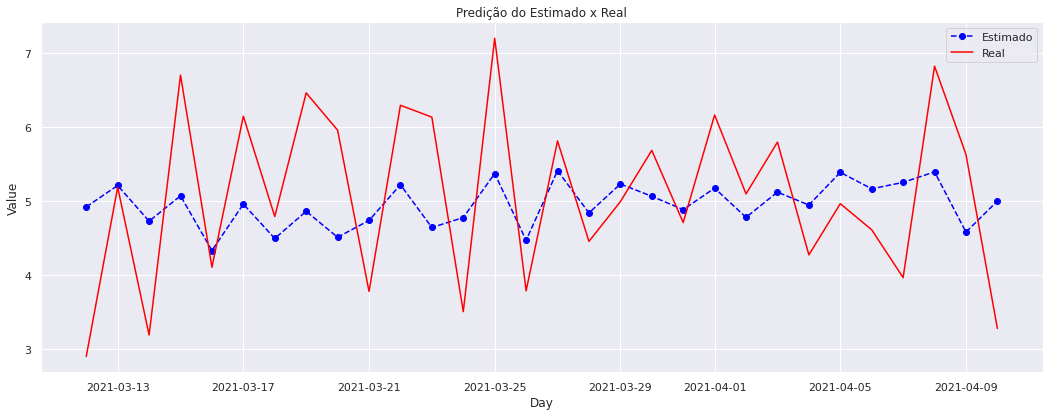

In [75]:
novo_teste = df_novo[int(len(df_novo)*0.7):].index
plt.plot(novo_teste, 
         modelo_pred, 
         color='blue',
         marker='o',
         linestyle='dashed',
         label='Estimado')

plt.plot(novo_teste, 
         dados_teste, 
         color='red', 
         label='Real')

plt.title('Predição do Estimado x Real')
plt.xlabel('Day')
plt.ylabel('Value')
plt.legend()
plt.show()

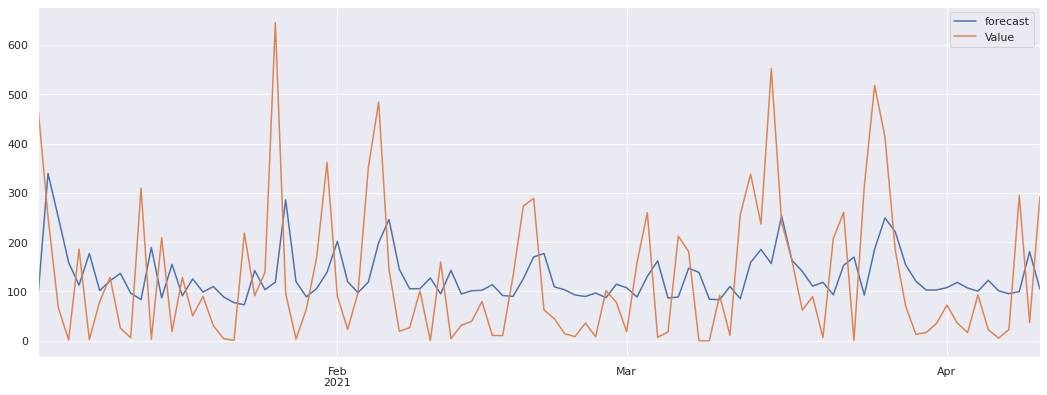

In [67]:
# Vamos verificar a previsão e também a precisão do modelo

model2.plot_predict(dynamic=False)
plt.show()

Gráficos: Previsão - Real x Estimado.

Os resultados são satisfatórios, mas é bom ter uma ideia de como o ARIMA funciona. Vamos fazer uma verificação rápida da métrica de precisão no mesmo para ver o quão bem o modelo pode prever o valor futuro.

In [69]:
train_df = df_novo[:90]
test_df = df_novo[90:]

In [70]:
train_df.head()

,Value
Day,
2021-01-01,4.981908
2021-01-02,3.735783
2021-01-03,7.471479
2021-01-04,4.528730
2021-01-05,3.500091


In [71]:
test_df.head()

,Value
Day,
2021-04-01,6.159867
2021-04-02,5.094363
2021-04-03,5.793782
2021-04-04,4.270255
2021-04-05,4.961898


In [72]:
# Modelo ARIMA 2 para conparação de precisão

model3 = sm.tsa.ARIMA(train_df, order=(1, 1, 1))  
fitted = model3.fit(disp=-1)

# Forecast
fc, se, conf = fitted.forecast(1, alpha=0.05)

# MAPE - Mean Absolute Percentage Error
mape = np.mean(np.abs(fc - test_df)/np.abs(test_df))

print('Valor previsto:{}'.format(fc))

Valor previsto:[5.17200702]


In [74]:
# MAPE - Mean Absolute Percentage Error

mape

Value    0.186435
dtype: float64

O MAPE é de 0.186435, ou seja, a precisão do modelo é de 99,81%. O Mean Absolute Percentage Error (MAPE) - erro percentual médio absoluto é um dos KPIs mais usados para medir a precisão da previsão.

O valor previsto pelo modelo final ARIMA foi 5.17200702.